# Add Libraries

In [1]:
import os
import time
import glob
import subprocess
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 8,          # Default font size
    'axes.titlesize': 10,    # Title font size
    'axes.labelsize': 9,     # Axis labels font size
    'xtick.labelsize': 8,    # X-axis tick labels font size
    'ytick.labelsize': 8,    # Y-axis tick labels font size
    'legend.fontsize': 8,    # Legend font size
    'figure.titlesize': 10   # Figure title font size
})
plt.rcParams['font.family'] = 'sans-serif'


AcD_color = plt.cm.Pastel1(3)
AcD_error_color = plt.cm.Paired(9)
nonAcD_color = plt.cm.Pastel2(5)
nonAcD_error_color = plt.cm.tab20b(9)

import numpy as np
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable
from scipy.special import expit
import ast


from core import core_global as core
from core.spike_monitor import SpikeMonitor
from core.voltage_monitor import VoltageMonitor
from core.weight_matrix_monitor import WeightMatrixMonitor
from layers.rewiring_connection import RewiringConnection
from models.poisson_pattern_group import PoissonPatternGroup
from utils import utils as utils

# Define functions for making the stats file for a simulation result
This file contains the number of connection and sum of synaptic weights by the end of the Exploration Phase.  

In [2]:
def _load_configuration(input_directory, experiment, keys):
    config = utils.load_configuration(os.path.join(
        input_directory, "..", "config_" + experiment + ".yaml"))

    if len(keys) > 1:
        return config[keys[0]][keys[1]]
    else:
        return config[keys[0]]


def _load_simulation_results(input_directory,cell_directory, experiment, key, gid=None,
                                     header_lenght=3):
    if key == "input_spike_times":
        data = np.loadtxt(os.path.join(input_directory, "input.0.ras"))
    if key == "input_spike_times_test":
        data = np.loadtxt(os.path.join(input_directory, "test_input.0.ras"))
    elif key == "output_spike_times":
        data = np.loadtxt(os.path.join(input_directory, "output.0.ras"))
    elif key == "output_spike_times_test":
        data = np.loadtxt(os.path.join(input_directory, "test_output.0.ras"))
    elif key == "weights_end":
        num_branches = _load_configuration(
            input_directory, experiment, ["neuron_parameters", "num_branches"])
        with open(os.path.join(cell_directory, "weights.0.dat"), "rb") as f:
            lines = f.readlines()
        if ((len(lines)-2)%13) != 0 :
            lines = lines[:-((len(lines)-2)%13)]
        end_w = np.loadtxt(lines[-num_branches:])
        if len(end_w) == num_branches:
            data = end_w
        else:
            data = np.loadtxt(lines[-(num_branches+1):])
    elif key == "weights_start":
        num_branches = _load_configuration(
            input_directory, experiment, ["neuron_parameters", "num_branches"])
        with open(os.path.join(cell_directory, "weights.0.dat"), "rb") as f:
            lines = f.readlines()
        data = np.loadtxt(lines[header_lenght:num_branches + header_lenght])
    elif key == "weights":
        with open(os.path.join(cell_directory, "weights.0.dat"), "rb") as f:
            lines = f.readlines()
        data = np.loadtxt(lines)
    elif key == "EPSP":
        with open(os.path.join(cell_directory, "EPSP.0.dat"), "rb") as f:
            lines = f.readlines()
        data = np.loadtxt(lines)
    
    elif key == "branch_mem":
        data = np.loadtxt(os.path.join(cell_directory, "branch" + str(gid) +
                                       ".0.mem"))
    elif key == "branch_mem_test":
        data = np.loadtxt(os.path.join(cell_directory, "test_branch" +
                                       str(gid) + ".0.mem"))
    elif key == "soma_mem":
        data = np.loadtxt(os.path.join(cell_directory, "soma.0.mem"))
    elif key == "soma_mem_test":
        data = np.loadtxt(os.path.join(cell_directory, "test_soma.0.mem"))
    elif key == "plateau_duration":
        data = np.loadtxt(os.path.join(cell_directory, "branch0.0.pla"))

    return data


def _get_represented_assemblies(weights, assembly_idc, min_summed_weight,
                                min_num_synapses):
    w = weights

    num_synapses = []
    summed_weight = []
    for i, assembly_idx in enumerate(assembly_idc):
        num_synapses.append(sum(np.heaviside(w[assembly_idx], 0)))
        summed_weight.append(
            sum(w[assembly_idx][w[assembly_idx] > 0], 0))

    idc = np.where(
        (np.asanyarray(summed_weight) >= min_summed_weight) &
        (np.asanyarray(num_synapses) >= min_num_synapses))[0].tolist()

    return idc, num_synapses, summed_weight


def _get_start_and_stop_times_of_test_patterns(experiment, input_directory):
    num_assemblies = _load_configuration(input_directory, experiment, ["input_parameters", "num_assemblies"])
    num_test_patterns_per_assembly = _load_configuration(input_directory, experiment, ["input_parameters",
                                                         "num_test_patterns_per_assembly"])
    num_patterns_per_assembly = _load_configuration(input_directory, experiment, ["input_parameters",
                                                    "num_patterns_per_assembly"])
    pattern_delay = _load_configuration(input_directory, experiment, ["input_parameters", "pattern_delay"])
    pattern_duration = _load_configuration(input_directory, experiment, ["input_parameters",
                                           "pattern_duration"])

    # Start and end times of test patterns.
    duration_test_patterns = (pattern_delay + pattern_duration) * \
        num_test_patterns_per_assembly * num_assemblies
    times_start = np.array(
        [((pattern_delay + pattern_duration) *
         num_patterns_per_assembly +
         i * (pattern_delay + pattern_duration) *
         (num_patterns_per_assembly +
         (num_assemblies * num_test_patterns_per_assembly)))
         for i in range(num_assemblies)])
    times_end = times_start + duration_test_patterns

    return times_start, times_end


def _compute_statistics(experiment, input_directory, cell_directory, logfile, min_summed_weight=50, min_num_synapses=10):
    num_branches = _load_configuration(input_directory, experiment, ["neuron_parameters", "num_branches"])
    num_assemblies = _load_configuration(input_directory, experiment, ["input_parameters", "num_assemblies"])
    assembly_size = _load_configuration(input_directory, experiment, ["input_parameters", "assembly_size"])

    weights_end = _load_simulation_results(input_directory, cell_directory, experiment, "weights_end")

    if experiment == "rewiring_ex5" or experiment == "rewiring_ex6":
        logfile.write("  Overlap:\n".encode())

        assembly_neurons_idc = np.loadtxt(os.path.join(input_directory, "assembly_neurons_idc"),
                                          dtype=np.int)
        overlap = np.zeros((len(assembly_neurons_idc), len(assembly_neurons_idc)))
        for i in range(len(assembly_neurons_idc)):
            for j in range(len(assembly_neurons_idc)):
                overlap[i, j] = np.intersect1d(
                    assembly_neurons_idc[i],
                    assembly_neurons_idc[j]).size / assembly_size

        np.savetxt(logfile, overlap, fmt="%9.3f")
        idc = np.triu_indices_from(overlap, k=1)
        logfile.write("\n  Mean overlap: {0:0.3f} var: {1:0.3f}\n\n".format(
            np.mean(overlap[idc]), np.var(overlap[idc])).encode())

    else:
        assembly_neurons_idc = np.split(np.arange(num_assemblies * assembly_size), num_assemblies)

    assemblies = []
    num_synapses_assembly = []
    summed_weight_assembly = []
    num_synapses = []
    summed_weight = []
    num_assemblies_per_branch = np.zeros(num_branches)
    for i in range(num_branches):
        logfile.write("  Branch: {0}\n".format(i).encode())

        idc, num_synapses, summed_weight = _get_represented_assemblies(
            weights_end[i], assembly_neurons_idc, min_summed_weight,
            min_num_synapses)

        if idc:
            assemblies.append(idc)
            num_assemblies_per_branch[i] = len(idc)
            logfile.write("    Assembly: {0}, N_syn: {1}, sum(w): {2}\n"
                          .format(assemblies[-1], num_synapses,
                                  [round(x) for x in summed_weight])
                          .encode())
            num_synapses_assembly.append([num_synapses[a]
                                          for a in assemblies[-1]])
            summed_weight_assembly.append([summed_weight[a]
                                          for a in assemblies[-1]])
        else:
            logfile.write("    Assembly: {0}, N_syn: {1}, sum(w): {2}\n"
                          .format(" ", num_synapses,
                                  [round(x) for x in summed_weight])
                          .encode())

    num_represented_assemblies = len(np.unique([a for l in assemblies
                                                for a in l]))
    logfile.write("\n  Represented assemblies {0}/{1}, {2}\n".format(
        num_represented_assemblies, num_assemblies, assemblies).encode())

    logfile.write("  Number of synapses per assembly" " {0:0.3f} SD:"
                  " {1:0.3f}\n".format(
                      np.mean([n for l in num_synapses_assembly for n in l]),
                      np.std([n for l in num_synapses_assembly for n in l]))
                  .encode())

    logfile.write("  Summed weight per assembly"
                  " {0:0.3f} SD: {1:0.3f}\n\n".format(
                      np.mean([s for l in summed_weight_assembly for s in l]),
                      np.std([s for l in summed_weight_assembly for s in l]))
                  .encode())

    if experiment == "rewiring_ex5" or experiment == "rewiring_ex6":
        idc = np.triu_indices_from(overlap, k=1)
        return (num_represented_assemblies, overlap, num_assemblies_per_branch)
    else:
        return num_represented_assemblies, num_assemblies_per_branch


def main(experiment, sim_date):

    comp_stats = True 

    # Directories of simulation results and log files.
    input_directories = sorted(glob.iglob(os.path.join("results", experiment, exp_result_name_folder, sim_date, "data")))
    cell_number = _load_configuration(
                    input_directories[0], experiment, ["num_neurons"])
    cell_directories = [sorted(glob.iglob(os.path.join("results", experiment, exp_result_name_folder, sim_date, "data","cell_recording",f"cell_num_{cell_ind}")))[0] for cell_ind in range(cell_number)]

    for cell_directory in cell_directories:
        paths = {}
        date = sim_date.split("/")[0]
        logfile_path = os.path.join(cell_directory, "stats.txt")
        if logfile_path in paths:
            paths[logfile_path].append(input_directories[0])
        else:
            paths[logfile_path] = [input_directories[0]]
        experiment = experiment.split("/")[0]

        neuron_activation_probability = []
        mean_num_represented_assemblies = []
        std_num_represented_assemblies = []
        for logfile_path, input_directories in paths.items():
            if comp_stats:
                logfile = open(logfile_path, "wb")

            if experiment == "rewiring_ex4":
                neuron_activation_probability.append(_load_configuration(
                              input_directory, experiment,
                              ["input_parameters",
                               "neuron_activation_probability"]))

            overlaps = []
            num_assemblies_per_branch = []
            num_represented_assemblies = []
            for trial, input_directory in enumerate(input_directories):
                if os.stat(os.path.join(cell_directory,
                                        "weights.0.dat")).st_size == 0:
                    continue



                if comp_stats and experiment != "test_plateau_duration":
                    # Compute some statistics.
                    logfile.write("Trial {0} (Data path: {1}):\n".format(
                        trial, input_directory).encode())

                    result = _compute_statistics(experiment, input_directory,cell_directory,logfile)
                    if experiment == "rewiring_ex5" or experiment == "rewiring_ex6":
                        num_represented_assemblies.append(result[0])
                        overlaps.append(result[1])
                        num_assemblies_per_branch.append(result[2])
                    else:
                        num_represented_assemblies.append(result[0])
                        num_assemblies_per_branch.append(result[1])


            mean_num_represented_assemblies.append(np.mean(num_represented_assemblies))
            std_num_represented_assemblies.append(np.std(num_represented_assemblies))

            if comp_stats:
                num_assemblies = _load_configuration(
                    input_directories[0], experiment, ["input_parameters", "num_assemblies"])

                logfile.write("Represented assemblies {0:0.3f} "
                              "SD: {1:0.3f}/{2} {3}\n"
                              .format(mean_num_represented_assemblies[-1],
                                      std_num_represented_assemblies[-1],
                                      num_assemblies,
                                      num_represented_assemblies).encode())
                logfile.write("Mean num assemblies per branch {0:0.3f} "
                              "SD: {1:0.3f}\n"
                              .format(np.mean(num_assemblies_per_branch),
                                      np.std(num_assemblies_per_branch)).encode())
                mm = []
                for i in range(num_assemblies + 1):
                    mm.append([list(num).count(i) for num in
                               num_assemblies_per_branch])
                m = np.mean(mm, axis=1)
                s = np.std(mm, axis=1)
                logfile.write("Num assemblies per branch\n"
                              "0:{0:0.3f} SD: {1:0.3f}\n1:{2:0.3f} SD: {3:0.3f}\n"
                              "2:{4:0.3f} SD: {5:0.3f}\n3:{6:0.3f} SD: {7:0.3f}\n"
                              "4:{8:0.3f} SD: {9:0.3f}\n"
                              "5:{10:0.3f} SD: {11:0.3f}\n"
                              "6:{12:0.3f} SD: {13:0.3f}\n"
                              .format(m[0], s[0], m[1], s[1], m[2], s[2], m[3],
                                      s[3], m[4], s[4], m[5], s[5], m[6], s[6]).encode())
                logfile.close()


# Make the stats files for all the cells in a simulation

In [3]:
simulation_list_date = ["241117_145956"]

exp_name = "rewiring_ex1"

exp_result_name_folder = 'wake_state'


for TRIAL_ind in range(len(simulation_list_date)):
    EXP_trial_number = TRIAL_ind
    EXP_simulation_date = simulation_list_date[TRIAL_ind]
    if __name__ == "__main__":
        import sys
        main(exp_name, f"{EXP_simulation_date}/{EXP_trial_number}")

# Count the number of Single-modalized and Multi-modalized cells

In [4]:
for i in range(len(simulation_list_date)):
    input_dir = f'results/{exp_name}/{exp_result_name_folder}/{simulation_list_date[i]}/0/data'
    cell_number = _load_configuration(input_dir, exp_name, ["num_neurons"])
    learned_assembly = np.zeros(cell_number)
    for cell_index in range(cell_number):
        u = 0
        with open(f'results/{exp_name}/{exp_result_name_folder}/{simulation_list_date[i]}/{i}/data/cell_recording/cell_num_{cell_index}/stats.txt', 'r') as f:
            for line in f:
                if u ==8:
                    learned_assembly[cell_index]=int(line.split('/9')[0][-1])
                u += 1

AcD_learned_assembly = learned_assembly[:50]
nonAcD_learned_assembly = learned_assembly[50:]

# Plot the Single-modalized vs. Multi-modalized population

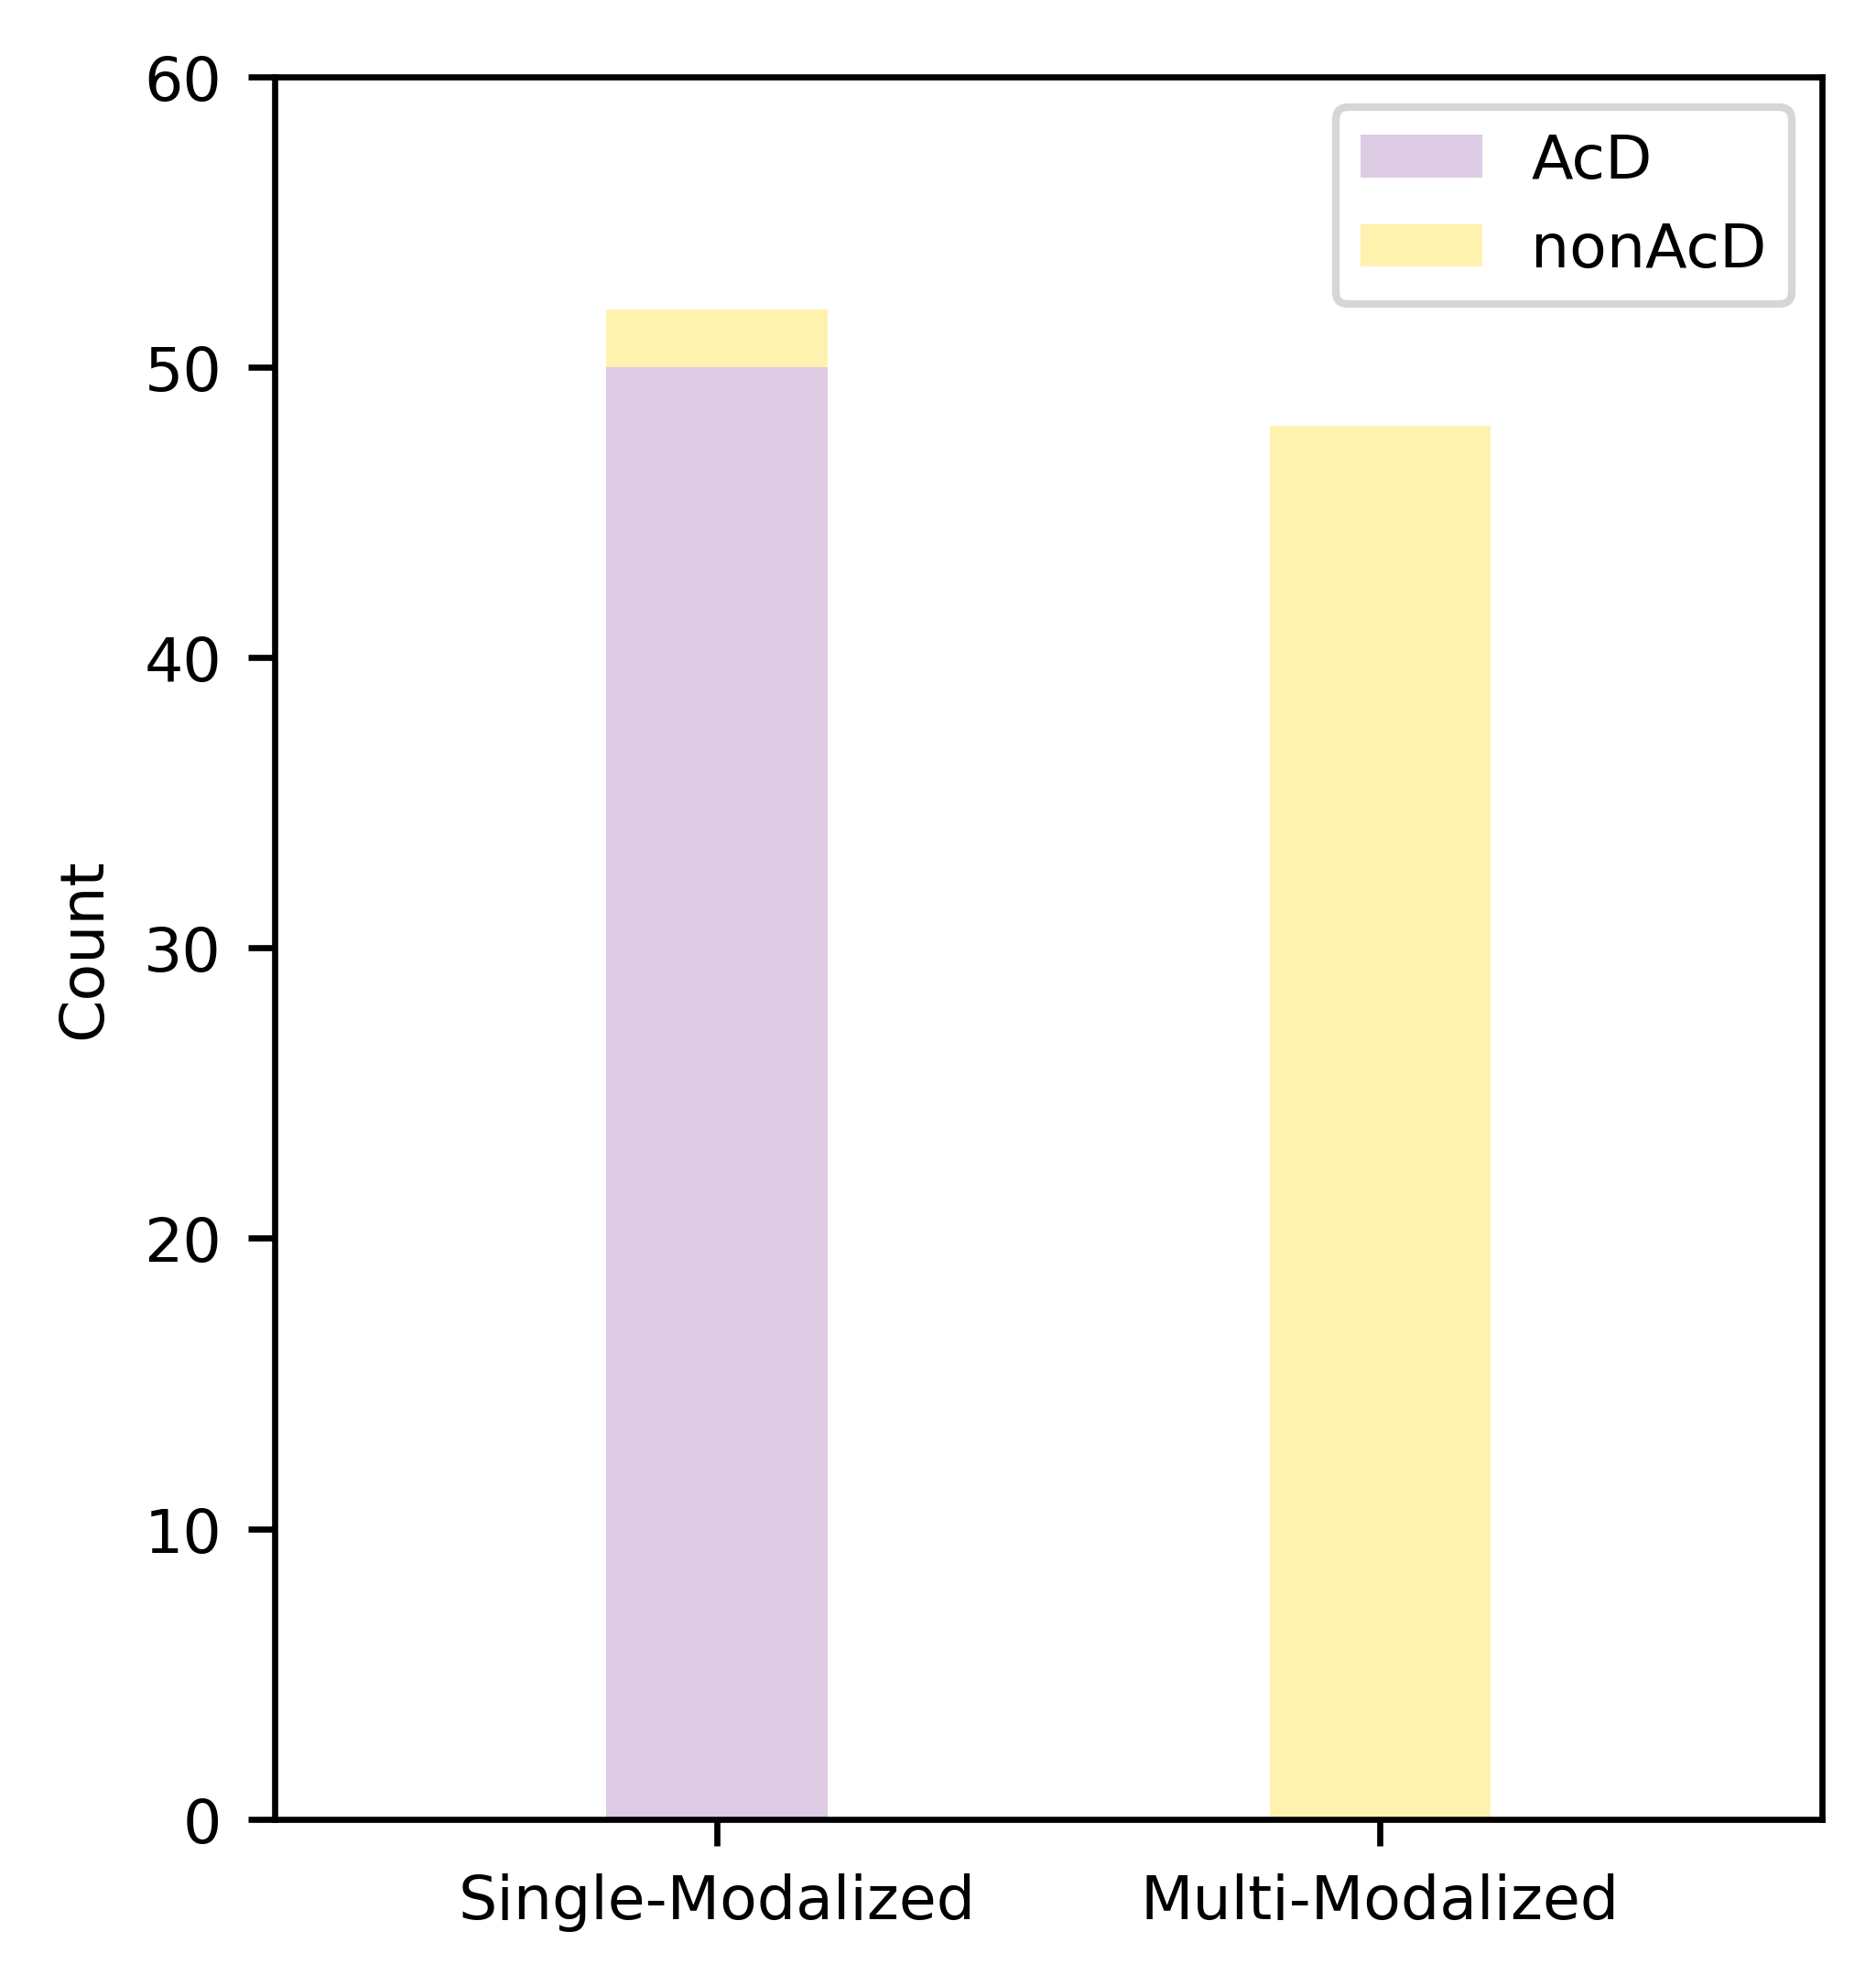

In [6]:
fig, axs = plt.subplots(figsize=(3.3, 3.5), dpi=600,constrained_layout = True)
x_pos = [0.45,0.75]
width_len = 0.1
color_plot = [plt.cm.Pastel1(3),plt.cm.Pastel1(4)]
###single
axs.bar(x_pos[0], len(AcD_learned_assembly[AcD_learned_assembly==1])+len(nonAcD_learned_assembly[nonAcD_learned_assembly==1]), width_len,color = nonAcD_color)
axs.bar(x_pos[0], len(AcD_learned_assembly[AcD_learned_assembly==1]), width_len,color = AcD_color)

####multi
axs.bar(x_pos[1], len(AcD_learned_assembly[AcD_learned_assembly>1])+len(nonAcD_learned_assembly[nonAcD_learned_assembly>1]), width_len,color = AcD_color,label ="AcD")
axs.bar(x_pos[1], len(nonAcD_learned_assembly[nonAcD_learned_assembly>1]), width_len,color = nonAcD_color,label ="nonAcD")


axs.set_xticks(x_pos,["Single-Modalized","Multi-Modalized"])
axs.set_xlim(0.25,0.95)
axs.set_ylim(0,60)
axs.set_ylabel('Count')
axs.legend()

plt.savefig("Figures/pdf/single_multi_population.pdf", format='pdf', bbox_inches='tight')
plt.savefig("Figures/svg/single_multi_population.svg", format='svg', bbox_inches='tight')
